## Import Library

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
df = pd.read_csv('sms_spam.csv')
df

,Unnamed: 0,v1,v2
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...
5567,5567,spam,This is the 2nd time we have tried 2 contact u...
5568,5568,ham,Will _ b going to esplanade fr home?
5569,5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,5570,ham,The guy did some bitching but I acted like i'd...


## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5572 non-null   int64 
 1   v1          5572 non-null   object
 2   v2          5572 non-null   object
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


In [4]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [5]:
df.rename(columns={'v1':'Type','v2':'Message'},inplace=True)
df.head()

,Type,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
label_encoder = LabelEncoder()

df['Type'] = label_encoder.fit_transform(df['Type'])

df.head()

,Type,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
print(label_encoder.classes_)

['ham' 'spam']


**Check for missing values**

In [8]:
df.isnull().sum()

Type       0
Message    0
dtype: int64

**Check for duplicate values**

In [9]:
df.duplicated().sum()

404

In [10]:
df = df.drop_duplicates(keep='first')
df.shape

(5168, 2)

## Data Preprocessing

In [11]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

set lookup: O(1) time (fast)

list lookup: O(n) time (slow if the list is long)

In [12]:
def preprocess(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    token = []

    for word in tokens:
        if word.isalnum() and word not in stop_words:
            stemmed = stemmer.stem(word)
            token.append(stemmed)

    return ' '.join(token)    

In [13]:
df['Preprocessed_text'] = df['Message'].apply(preprocess)

In [14]:
df

,Type,Message,Preprocessed_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,2nd time tri 2 contact u 750 pound prize 2 cla...
5568,0,Will _ b going to esplanade fr home?,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,guy bitch act like interest buy someth els nex...


## Model Building and Testing

Here spam = 1 and ham = 0  
i.e.  spam = positive class and ham = negative class

In confusion matrix,    
**TP** = Spam predicted as spam    
**FP** = Ham wrongly predicted as spam    
**FN** = Spam wrongly predicted as ham    
**TN** = Ham correctly predicted as ham   

Our goal is classify in such a way that **Ham cannot wrongly predicted as spam**  or  **Predictio of Ham wrongly as spam must be very less**    

That's why we try to make ourr accuracy is higher with precision as 1 or almost near 1

In [15]:
X = df['Preprocessed_text']
y = df['Type']

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

In [17]:
import pandas as pd

# Convert y_train into a pandas Series
y_train_series = pd.Series(y_train)

# Now check counts
print(y_train_series.value_counts())


Type
0    3612
1     522
Name: count, dtype: int64


**Text Vectorization using TF-IDF (Unigrams & Bigrams)**

In [18]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000,ngram_range=(1,2))

In [19]:
# Fit only on augmented training set
X_train_vec = tfidf.fit_transform(X_train).toarray()

# Transform the untouched test set with the same vectorizer
X_test_vec = tfidf.transform(X_test).toarray()

**Applying Class Balancing with Sample Weights**

In [20]:
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights for balancing
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

**check the values of weight**

In [21]:
# Get unique classes and their corresponding weights
unique_classes = np.unique(y_train)
class_weight_mapping = {}

for cls in unique_classes:
    # Get indices of samples belonging to this class
    class_indices = np.where(y_train == cls)[0]
    # All samples of the same class should have the same weight
    class_weight = sample_weights[class_indices[0]]
    class_weight_mapping[cls] = class_weight
    print(f"Class {cls}: Weight = {class_weight:.4f}, Samples = {len(class_indices)}")

# Optional: Verify the formula
total_samples = len(y_train)
n_classes = len(unique_classes)
for cls in unique_classes:
    class_count = np.sum(y_train == cls)
    calculated_weight = total_samples / (n_classes * class_count)
    print(f"Class {cls}: Calculated weight = {calculated_weight:.4f}")


Class 0: Weight = 0.5723, Samples = 3612
Class 1: Weight = 3.9598, Samples = 522
Class 0: Calculated weight = 0.5723
Class 1: Calculated weight = 3.9598


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [23]:
# Classifiers that support class_weight
svc = SVC(kernel='sigmoid', gamma=1.0, probability=True, class_weight='balanced')
dtc = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
lrc = LogisticRegression(solver='liblinear', penalty='l1', class_weight='balanced')
rfc = RandomForestClassifier(n_estimators=50, random_state=2, class_weight='balanced')
etc = ExtraTreesClassifier(n_estimators=50, random_state=2, class_weight='balanced')

# Classifiers that do NOT support class_weight
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)

# Handle XGBoost separately
if len(np.unique(y_train)) == 2:
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
    xgb = XGBClassifier(n_estimators=50, random_state=2, scale_pos_weight=scale_pos_weight)
else:
    xgb = XGBClassifier(n_estimators=50, random_state=2)

In [24]:
clfs = {
    'SVC' : svc,
    'M_NB': mnb,
    'B_NB': bnb, 
    'G_NB': gnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def train_classifier(clf, X_train, y_train, X_test, y_test, sample_weights=None):
    if sample_weights is not None:
        clf.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary')  
    rec = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    report = classification_report(y_test, y_pred)
    
    return acc, prec, rec, f1, report

In [26]:
accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for name, clf in clfs.items():
    # Use sample weights for classifiers that don’t support class_weight
    if name in ['M_NB', 'G_NB', 'B_NB', 'AdaBoost', 'BgC', 'GBDT']:
        acc, prec, rec, f1, report = train_classifier(clf, X_train_vec, y_train, X_test_vec, y_test, sample_weights=sample_weights)
    else:
        acc, prec, rec, f1, report = train_classifier(clf, X_train_vec, y_train, X_test_vec, y_test)
    
    print(f"\nFor {name}:")
    print("Accuracy -", acc)
    print("Precision -", prec)
    print("Recall -", rec)
    print("F1-score -", f1)
    print("Classification Report:\n", report)
    
    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)


For SVC:
Accuracy - 0.9632495164410058
Precision - 0.8066666666666666
Recall - 0.9307692307692308
F1-score - 0.8642857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       904
           1       0.81      0.93      0.86       130

    accuracy                           0.96      1034
   macro avg       0.90      0.95      0.92      1034
weighted avg       0.97      0.96      0.96      1034


For M_NB:
Accuracy - 0.9458413926499033
Precision - 0.7283950617283951
Recall - 0.9076923076923077
F1-score - 0.8082191780821918
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       904
           1       0.73      0.91      0.81       130

    accuracy                           0.95      1034
   macro avg       0.86      0.93      0.89      1034
weighted avg       0.95      0.95      0.95      1034


For B_NB:
Accuracy - 0.981624758220502

In [27]:
import pandas as pd

# Create performance DataFrame
performance_df = pd.DataFrame({
    'Algorithm': clfs.keys(),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-score': f1_scores
})

# Sort by F1-score descending
performance_df = performance_df.sort_values('Precision', ascending=False)

# Reset index for cleaner display
performance_df = performance_df.reset_index(drop=True)

print(performance_df)

   Algorithm  Accuracy  Precision    Recall  F1-score
0       B_NB  0.981625   1.000000  0.853846  0.921162
1        ETC  0.978723   1.000000  0.830769  0.907563
2         RF  0.970986   0.990196  0.776923  0.870690
3        xgb  0.954545   0.816794  0.823077  0.819923
4        SVC  0.963250   0.806667  0.930769  0.864286
5        BgC  0.946809   0.786260  0.792308  0.789272
6         LR  0.945841   0.743421  0.869231  0.801418
7       M_NB  0.945841   0.728395  0.907692  0.808219
8       GBDT  0.923598   0.650888  0.846154  0.735786
9         DT  0.902321   0.590062  0.730769  0.652921
10  AdaBoost  0.904255   0.586592  0.807692  0.679612
11      G_NB  0.866538   0.483333  0.892308  0.627027


In [28]:
performance_df

,Algorithm,Accuracy,Precision,Recall,F1-score
0,B_NB,0.981625,1.000000,0.853846,0.921162
1,ETC,0.978723,1.000000,0.830769,0.907563
2,RF,0.970986,0.990196,0.776923,0.870690
3,xgb,0.954545,0.816794,0.823077,0.819923
4,SVC,0.963250,0.806667,0.930769,0.864286
5,BgC,0.946809,0.786260,0.792308,0.789272
6,LR,0.945841,0.743421,0.869231,0.801418
7,M_NB,0.945841,0.728395,0.907692,0.808219
8,GBDT,0.923598,0.650888,0.846154,0.735786
9,DT,0.902321,0.590062,0.730769,0.652921


**Voting Classifier**

In [29]:
from sklearn.ensemble import VotingClassifier

In [30]:
voting = VotingClassifier(estimators=[('B_NB', bnb),('et',etc),('rf',rfc)],voting='soft')

In [31]:
voting.fit(X_train_vec,y_train)

VotingClassifier(estimators=[('B_NB', BernoulliNB()),
                             ('et',
                              ExtraTreesClassifier(class_weight='balanced',
                                                   n_estimators=50,
                                                   random_state=2)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     n_estimators=50,
                                                     random_state=2))],
                 voting='soft')

Accuracy: 0.9748549323017408
Precision: 1.0
Recall: 0.8
F1 Score: 0.8888888888888888

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       904
           1       1.00      0.80      0.89       130

    accuracy                           0.97      1034
   macro avg       0.99      0.90      0.94      1034
weighted avg       0.98      0.97      0.97      1034



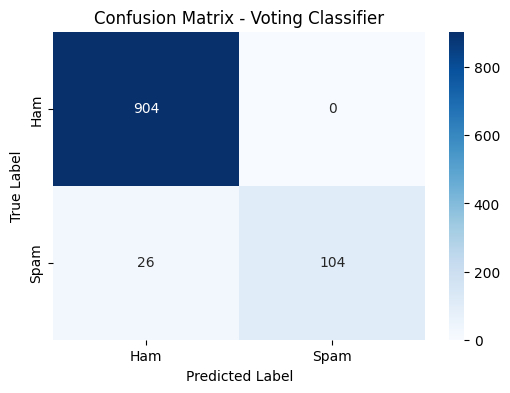

In [32]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = voting.predict(X_test_vec)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Voting Classifier')
plt.show()


ROC AUC Score: 0.975791354663036


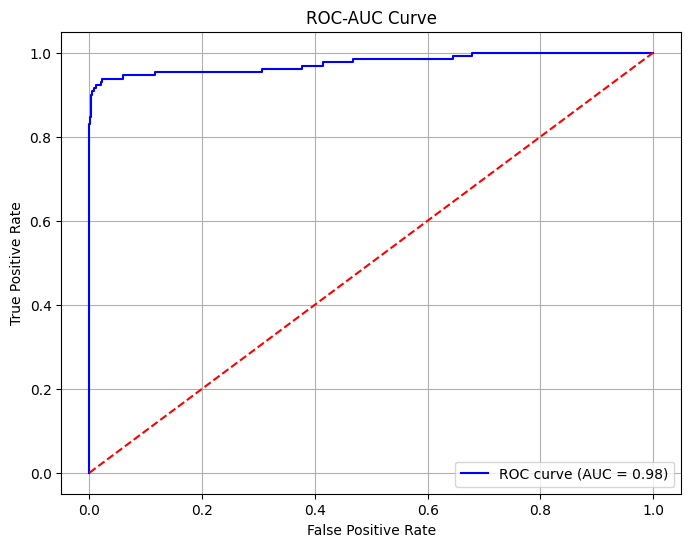

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for positive class (Spam = 1)
y_prob = voting.predict_proba(X_test_vec)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Applying stacking**

In [34]:
from sklearn.ensemble import StackingClassifier

In [35]:
final_estimator=RandomForestClassifier()

clf = StackingClassifier(estimators=[('B_NB', bnb),('rf',rfc),('et',etc)], final_estimator=final_estimator)

In [36]:
clf.fit(X_train_vec,y_train)

StackingClassifier(estimators=[('B_NB', BernoulliNB()),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=50,
                                                       random_state=2)),
                               ('et',
                                ExtraTreesClassifier(class_weight='balanced',
                                                     n_estimators=50,
                                                     random_state=2))],
                   final_estimator=RandomForestClassifier())

Accuracy: 0.9758220502901354
Precision: 0.9338842975206612
Recall: 0.8692307692307693
F1 Score: 0.900398406374502

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       904
           1       0.93      0.87      0.90       130

    accuracy                           0.98      1034
   macro avg       0.96      0.93      0.94      1034
weighted avg       0.98      0.98      0.98      1034



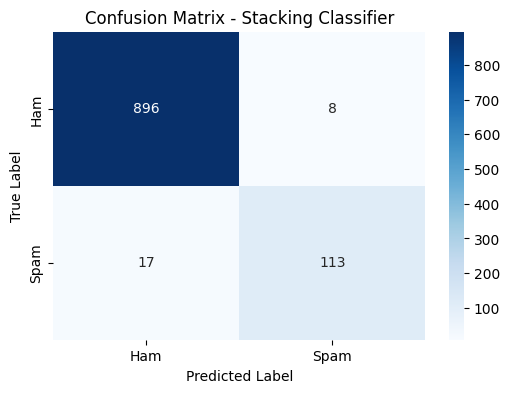

In [37]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions using StackingClassifier
y_pred_stack = clf.predict(X_test_vec)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Precision:", precision_score(y_test, y_pred_stack))
print("Recall:", recall_score(y_test, y_pred_stack))
print("F1 Score:", f1_score(y_test, y_pred_stack))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))

# Confusion matrix
cm_stack = confusion_matrix(y_test, y_pred_stack)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(
    cm_stack, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Stacking Classifier')
plt.show()


ROC AUC Score: 0.9781484002722941


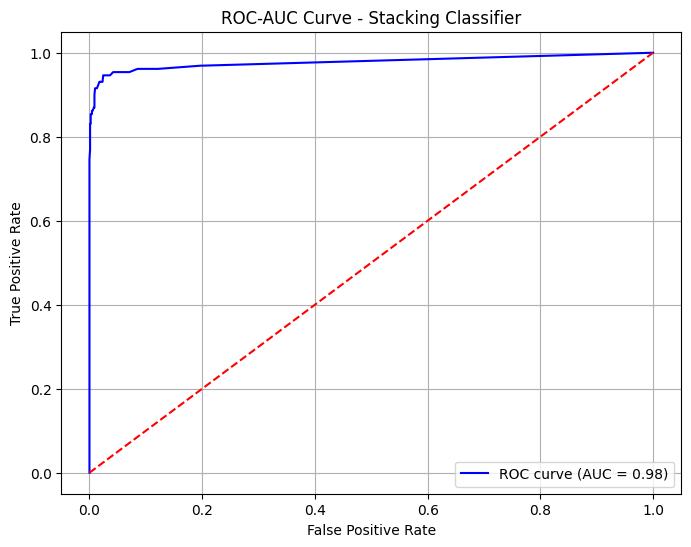

In [39]:
# Get predicted probabilities for positive class (Spam = 1)
y_prob_stack = clf.predict_proba(X_test_vec)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_stack)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob_stack)
print("ROC AUC Score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve - Stacking Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
